In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy




import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

import time

from tqdm import tqdm

In [2]:
plt.style.use('plot_style-Examples.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [3]:
from jax.scipy import integrate
def compute_2d_error(pred, u, x, y):
    norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u**2, x), y))
    norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred - u)**2, x), y))
    return norm_diff, norm_diff/norm_u

def compute_1d_error(pred, u, x):
    norm_u = jnp.sqrt(integrate.trapezoid(u**2, x))
    norm_diff = jnp.sqrt(integrate.trapezoid((pred - u)**2, x))
    return norm_diff, norm_diff/norm_u

# Benchmark: stochastic heat equation with spectral decomposition


We will solve

\begin{align}
&du = \Delta u dt  + dW_t \\
&u(0, x) = g(x) \\
&u(t,0) = u(t, 1) = 0
\end{align}

Let 
$$
u = \sum_{j=1}^\infty u_j(t)  \sqrt{2}\sin(j\pi x)
$$
Let 
\begin{align}
\phi_i &=  \sqrt{2}\sin(i\pi x) \\
-\Delta \phi_i &= j^2 \pi^2 \sqrt{2} \phi_j = \lambda_j \phi_j
\end{align}
Then the weak solution is given by 

$$
\langle du(t), \phi_i\rangle = - \langle u(t), -\Delta \phi_i  \rangle + \sigma \langle dW_t, \phi_i\rangle 
$$

Let 
$$
dW_t = \sum_{j=1} dB_j(t) \phi_j
$$
we BM in time, white noise is space. The above then becomes

$$
du^j = -\pi^2 j^2  u^jdt + \sigma dB^j(t)
$$
which is an OU process and can be simulated accurately.

We will use the explicit form 

$$
u^j_t = u_0 e^{-\pi^2 j^2 t} + \sigma  e^{-\pi^2 j^2 t}\int_{0}^t e^{\pi^2 j^2s}dW_s
$$

and discretize the integral 
$$
\int_{0}^t e^{\pi^2 j^2s}dW_s \approx \sum_{i=1}^N e^{\pi^2 j^2s_i}\Delta W_i
$$


CFL condition: we need 

$$
\lambda_N h = C
$$
where $h$ is the timestep.
But

$$
\lambda_N = \nu\pi^2 N^2
$$

Hence we need 

$$
\nu\pi^2 N^2 h = C
$$

Hence we would like to choose

$$
N^2 h = \frac{1}{\nu\pi^2}
$$

In practice this is difficult to do.

In [4]:
from utils_DST import discrete_sine_transform, vmap_dst, vmap_compute_sine_coef

In [229]:
key = random.PRNGKey(12)


n_coef = 2**11
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:] # Do not include 0 or 1!
print(n_coef)

frequencies = jnp.arange(0, n_coef) + 1

# This is the initial condition
coef_g = -jnp.hstack([random.normal(key, shape= (n_coef,))])/(0.01*frequencies**2*jnp.pi**2  +1)

g_values = discrete_sine_transform(coef_g)

2048


In [230]:
# key = random.PRNGKey(12)


# n_coef = 2**10
# upper = 1.0
# lower = 0.0
# boundary = jnp.array([lower, upper])
# boundary_conditions = jnp.array([0.0, 0.0])

# domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:] # Do not include 0 or 1!
# print(n_coef)

# frequencies = jnp.arange(0, n_coef) + 1

# # This is the initial condition
# coef_g = jnp.hstack([random.normal(key, shape= (n_coef,))])/(0.01*frequencies**2*jnp.pi**2  +1)

# g_values = discrete_sine_transform(coef_g)

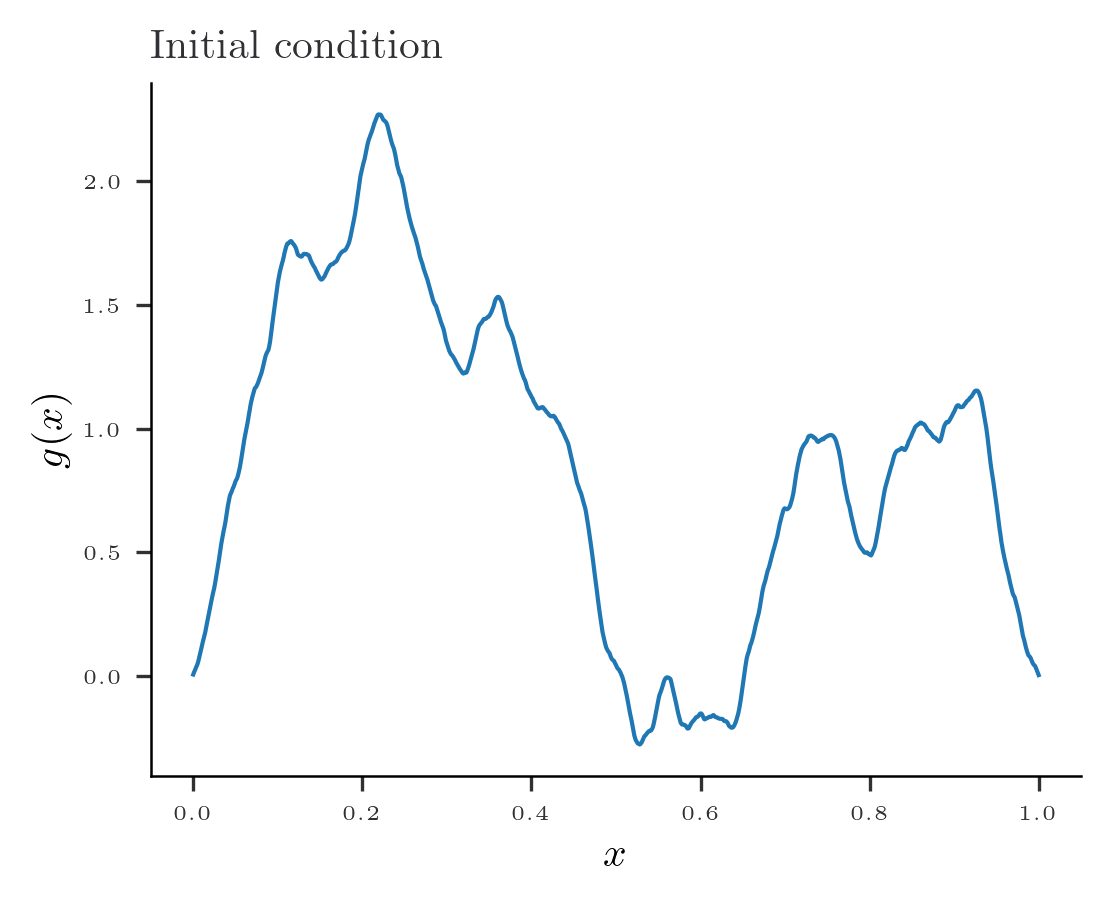

In [231]:
# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, g_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$g(x)$")
plt.title(r"Initial condition")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

In [7]:
def convolve(K, Z):
    return scipy.signal.convolve(K, Z, mode='full')[:Z.shape[0]]

In [8]:
def OU_explicit(time_span, h, u_init, beta, sigma, BM):
    """
    time span should not contain the time 0.0
    """

    # Create the convolution kernel
    K = jnp.exp(-beta*time_span)
    u = u_init*jnp.exp(-beta*time_span) + sigma*jnp.sqrt(h)*convolve(K, BM)

    return jnp.hstack([u_init, u])

OU_system = jit(vmap(OU_explicit, in_axes=(None, None, 0, 0, None, 0)))

In [17]:
# nu = 0.1
# beta = nu*jnp.pi**2*jnp.arange(1, n_coef+1)**2

# h_spectral  = 1e-4
# T = 0.5
# sigma = 0.1


# time_span = jnp.arange(0, T +h_spectral, h_spectral)
# BM = random.normal(key, (n_coef, time_span.shape[0]-1))

# print(1/(n_coef**2))

#OU_explicit(time_span[1:], h_spectral, coef_g[0], beta[0], sigma, BM[0])

In [232]:
nu = 0.025
beta = nu*jnp.pi**2*jnp.arange(1, n_coef+1)**2

h_spectral  = 1e-4
T = 0.5
sigma = 0.1


time_span = jnp.arange(0, T +h_spectral, h_spectral)
key = random.PRNGKey(0)
BM = random.normal(key, (n_coef, time_span.shape[0]-1))

u_hist = OU_system(time_span[1:], h_spectral, coef_g, beta, sigma, BM)
u_values_T = vmap_dst(u_hist.T)

In [233]:
l = -1
jnp.max(u_values_T[l] - discrete_sine_transform(u_hist[:, l]))

Array(0., dtype=float64)

In [234]:
# temp = 0

# t_idx = -1
# c_idx =23
# b = beta[c_idx]

# W = 0
# for i, t in enumerate(time_span[:t_idx]):
#     W += BM[c_idx, i]*jnp.exp(b*(t- time_span[t_idx]))*jnp.sqrt(h)


# jnp.exp(-b*time_span[t_idx])*coef_g[c_idx]   + sigma*W, u_hist[c_idx,t_idx]

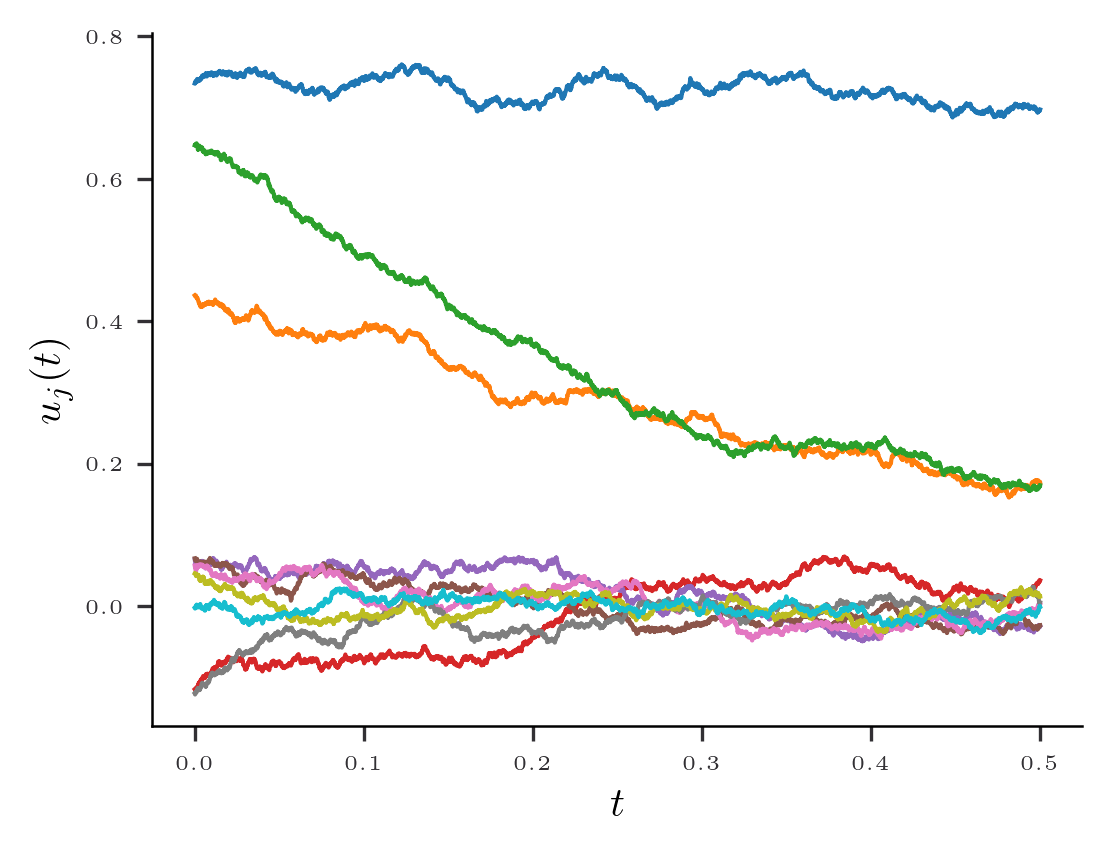

In [235]:
max_freq =10 
fig = plt.figure(figsize=(width, height))
for i in range(max_freq):
    plt.plot(time_span, u_hist[i], label=f"Frequency {i+1}")
plt.xlabel(r"$t$")
plt.ylabel(r"$u_j(t)$")
plt.show()

In [236]:
plt.style.use('default')
plt.style.use('plot_style-Examples_3d.txt')


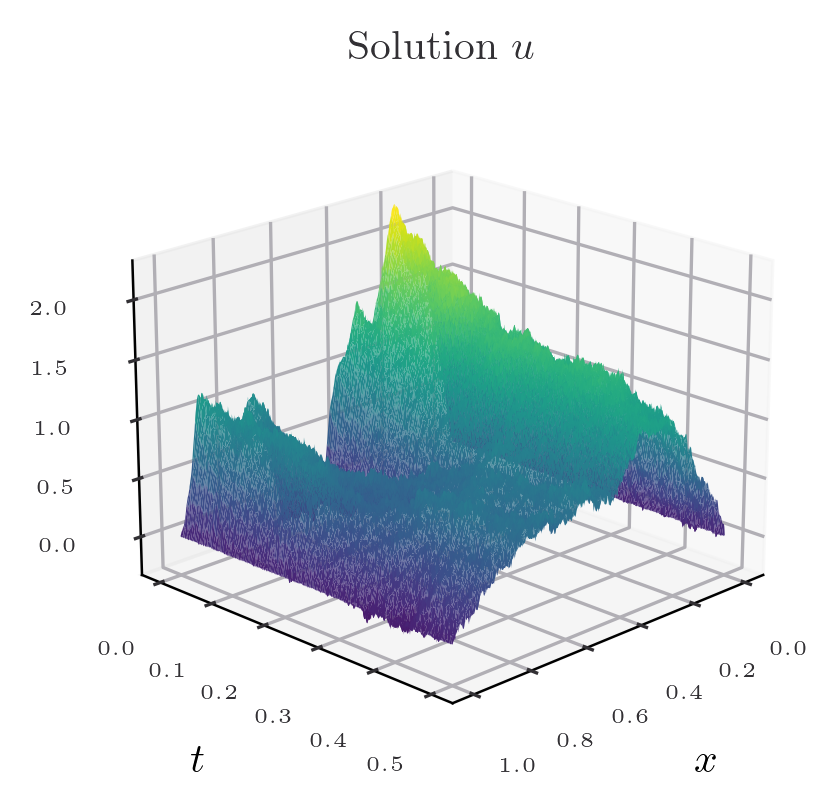

In [237]:

# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

X, time_grid = jnp.meshgrid(domain_finest, time_span)
stride = 25
ax.plot_surface(X, time_grid, u_values_T,  cmap='viridis',  rstride=stride, cstride=stride)


#ax.plot_surface(X, time_grid, u_values_T,  cmap='viridis')
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

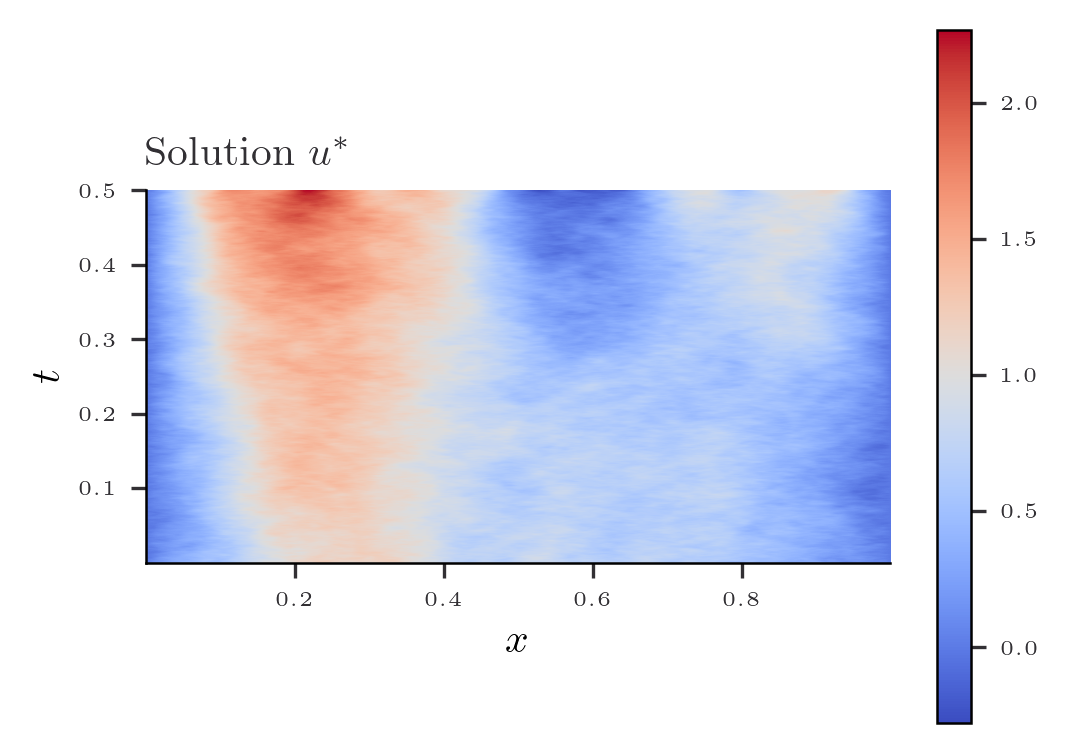

In [238]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values_T[1:], cmap='coolwarm', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Solving time dependent systems

## Stochastic heat equation

We will solve 

\begin{align}
&du = \Delta u dt  + dW_t \\
&u(0, x) = g(x) \\
&u(t,0) = u(t, 1) = 0
\end{align}

where $\frac{dW_t}{dt}$ is space time white noise. We use an implicit EM method with step size $h$

\begin{align}
&u_0 = g(x) \\
&u_{n+1} = u_n + h \Delta u_{n+1} + \Delta W_n
\end{align}
where 
$$
\Delta W_n \sim \mathcal{N}(0, h I)
$$


Hence 
\begin{align}
&(-h \Delta + I )u_{n+1} = u_n + \Delta W_n\\
&u(t,0) = u(t, 1) = 0
\end{align}

At each step we solve

\begin{align}
[(-h \Delta + I )u_{n+1}, \psi] = [u_n,\psi] + \sqrt{h}[\Delta \xi_n, \psi]
\end{align}



In [240]:
# Generate our Galerkin basis
n_intervals = 2**10
n_meas = n_intervals -1 # We do not include the boundary points
print(n_intervals)
epsilon = (upper- lower)/n_intervals
centers = jnp.linspace(lower, upper, n_intervals + 1)
epsilon = (upper - lower)/n_intervals
epsilon_values  = jnp.ones(n_intervals)*epsilon
intervals = jnp.array([centers[:-1], centers[1:]]).T

1024


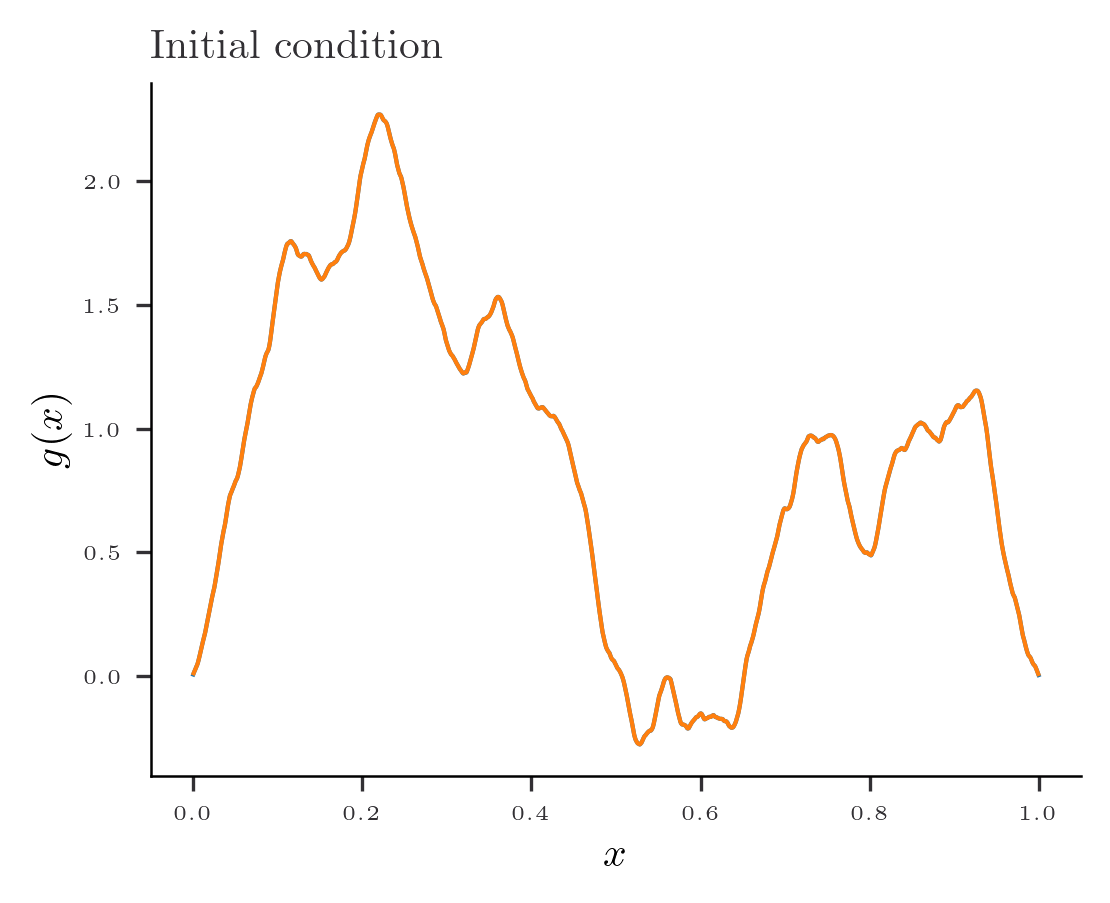

In [241]:
tent_values = vmap_tent(domain_finest, epsilon, centers[1:-1]) # Evaluate the tent functions on the fine grid
tent_proj_coef = vmap_compute_sine_coef(tent_values)  # Project the tent functions onto the sine basis
g_tent = tent_proj_coef@coef_g # We can now project the initial condition onto the tent functions

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, g_values)
plt.plot(centers[1:-1], g_tent)
plt.xlabel(r"$x$")
plt.ylabel(r"$g(x)$")
plt.title(r"Initial condition")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

In [242]:
from utils_rough_pde import vmap_root_interval
from scipy.special import roots_legendre

n_quad = 3
print(n_quad*2-1)
x_q, w_q = roots_legendre(n_quad)
# Quadrature node for the tent element
x_element, w_element = root_interval(x_q, w_q, jnp.array([0, 1]))


# Quadrature node for the kernel
x_quad, w_quad = vmap_root_interval(x_q, w_q, intervals)
k_quad = []
for i in range(n_meas):
    k_quad.append(jnp.hstack([x_quad[i], x_quad[i+1]]))
k_quad = jnp.array(k_quad)

5


In [243]:
# The fundamental element
def tent_element(x, normalization = 1.0):
    
    element = jnp.maximum(0, 1 + (x - 1) )
    

    # Set the element to zero outside the interval
    element = jnp.where(x < 0.0, 0.0, element)
    element = jnp.where(x > 1.0, 0.0, element)

    return element/normalization

element_quad = tent_element(x_element, normalization = 1.0)
tent_quad = jnp.hstack([element_quad, element_quad[::-1]])*jnp.hstack([w_element, w_element[::-1]])

In [244]:
import importlib
import utils_optim
importlib.reload(utils_optim)

from utils_optim import kernel_linear_solver

# length_scale = 1.0
# solver = kernel_linear_solver(length_scale,  tent_quad, k_quad, boundary[:, None], boundary_conditions, 1.0)

In [245]:
h = h_spectral
time_span = jnp.arange(0, T + h, h)
b =lambda x : jnp.ones_like(x)
root_b= b(k_quad)
length_scale = 0.1

In [246]:
linear_solver = kernel_linear_solver(length_scale, tent_quad, k_quad,  boundary[:, None], boundary_conditions, h*nu)


start = time.time()
linear_solver.build_matrices(root_b)
linear_solver.create_K_psi()
linear_solver.create_K_eval(domain_finest)
end = time.time()
print("Time to build the matrices", jnp.round(end - start, 5))

Time to build the matrices 0.23605


In [247]:
linear_solver.solve(g_tent, None, None, compute_residuals = False)

In [248]:
linear_solver.evaluate_solution_psi()

Array([0.00929118, 0.01815853, 0.02689359, ..., 0.02400047, 0.01608468,
       0.00801012], dtype=float64)

In [249]:
def implicit_EM_solver(time_span, h, linear_solver, y_init,sigma, BM):

    y = y_init

    #noise = []
    c_history = []
    for i,t  in enumerate(time_span):
        # Sample from the space time white noise
        xi = BM[:, i]

        # Create the right hand side
        rhs = y + sigma*xi
        #print(xi[0])

        # Solve the linear system
        linear_solver.solve(rhs, None, None, compute_residuals = False)

        # Update the rhs
        y = linear_solver.evaluate_solution_psi()    

        c_history.append(linear_solver.c)    
        #print(y.shape)

    return y, linear_solver, jnp.array(c_history)

In [250]:
xi_tent = tent_proj_coef@BM*jnp.sqrt(h_spectral)

In [251]:
xi_tent.shape

(1023, 5000)

In [252]:
start = time.time()
y, linear_solver, c_kernel_history= implicit_EM_solver(time_span[1:], h, linear_solver, g_tent, sigma,xi_tent)
end = time.time()
print("Time to integrate the system", jnp.round(end - start, 5))

Time to integrate the system 18.13898


In [253]:
pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)

In [254]:
pred_kernel.shape, time_span.shape

((5000, 2048), (5001,))

In [255]:
compute_2d_error(pred_kernel, u_values_T[1:], domain_finest, time_span[1:])

(Array(0.00272898, dtype=float64), Array(0.0044201, dtype=float64))

In [256]:
error_T, rel_error_T = vmap(compute_1d_error, in_axes=(0, 0, None))(pred_kernel, u_values_T[1:], domain_finest)

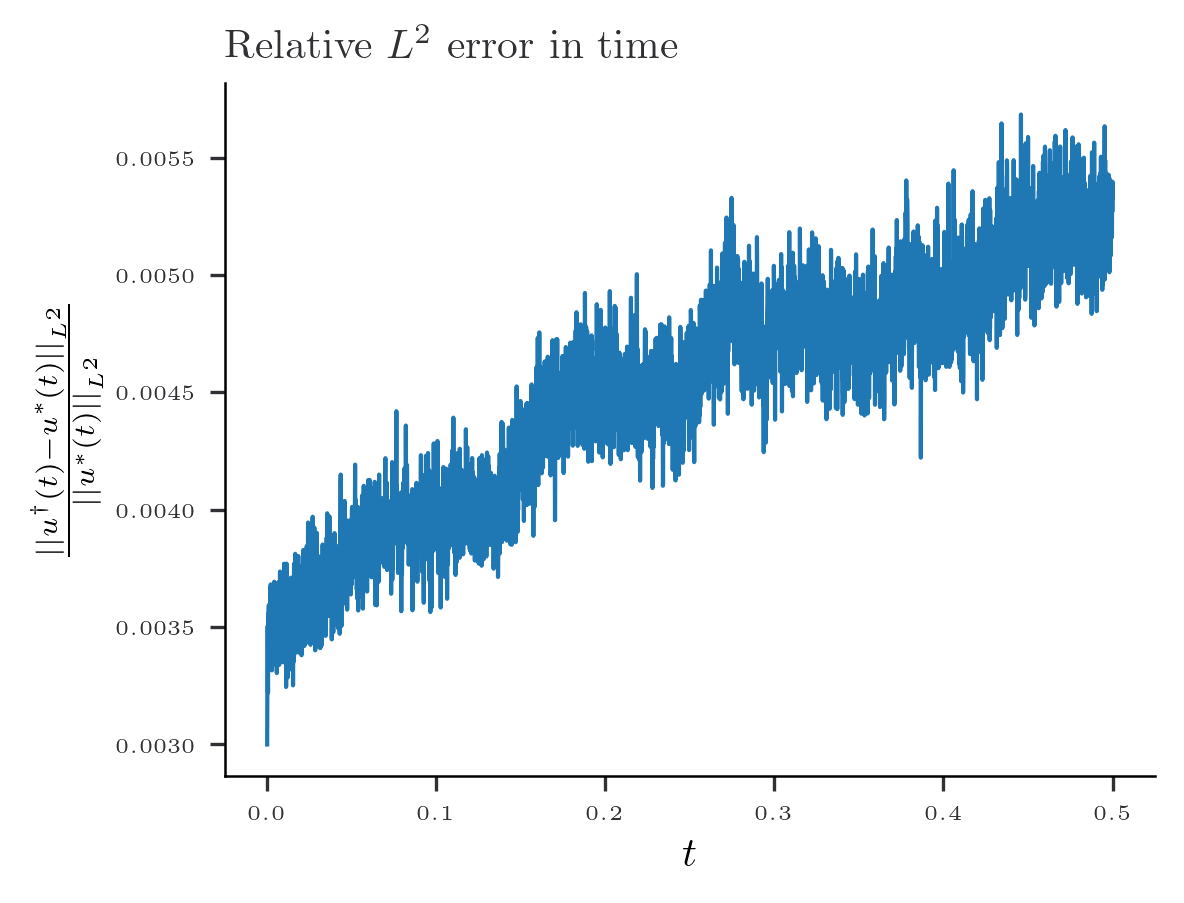

In [257]:
# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(time_span[1:], rel_error_T)
plt.xlabel(r"$t$")
plt.ylabel(r"$\frac{||u^\dagger(t)-u^*(t) ||_{L^2}}{||u^*(t)||_{L^2}}$")
plt.title(r"Relative $L^2$ error in time")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

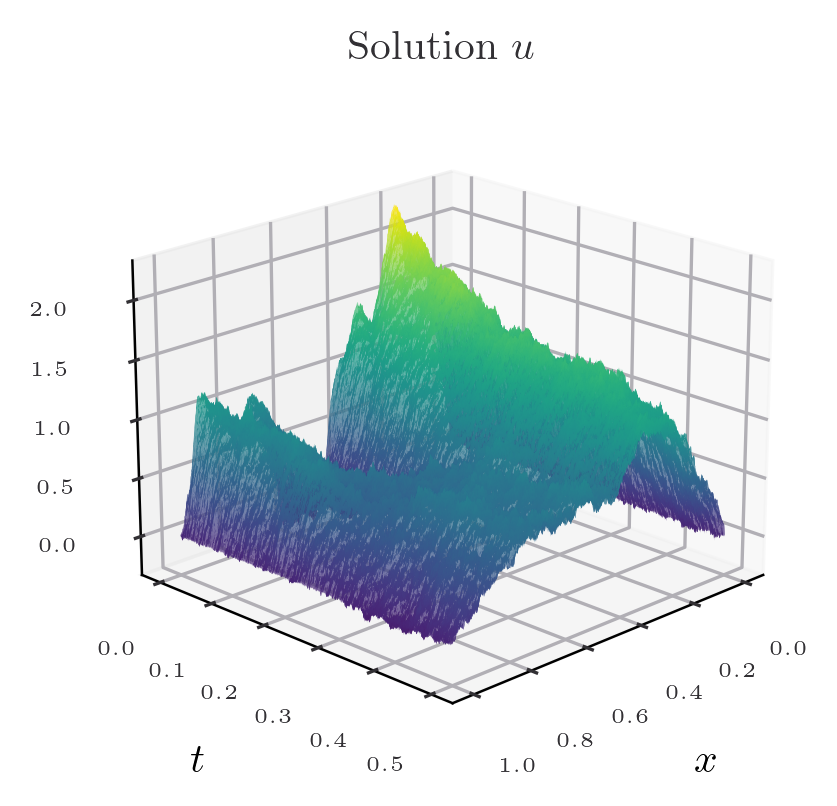

In [258]:

# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

X, time_grid = jnp.meshgrid(domain_finest, time_span[1:])
stride = 25
ax.plot_surface(X, time_grid, pred_kernel,  cmap='viridis',  rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

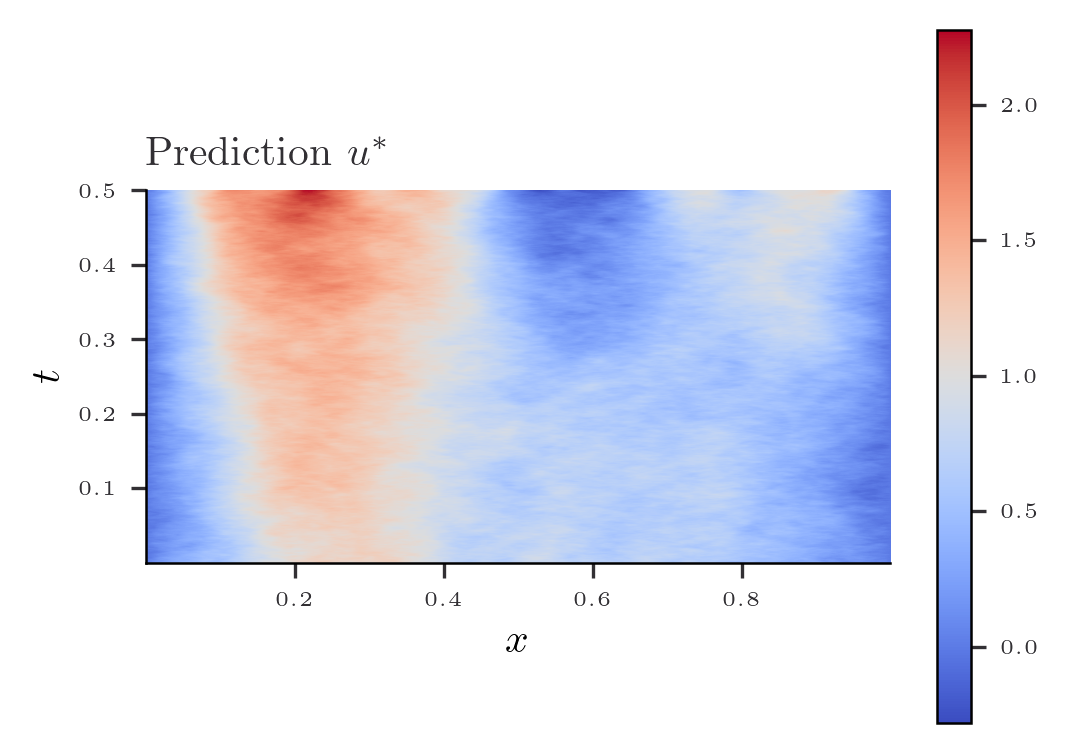

In [259]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_kernel, cmap='coolwarm', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Prediction $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

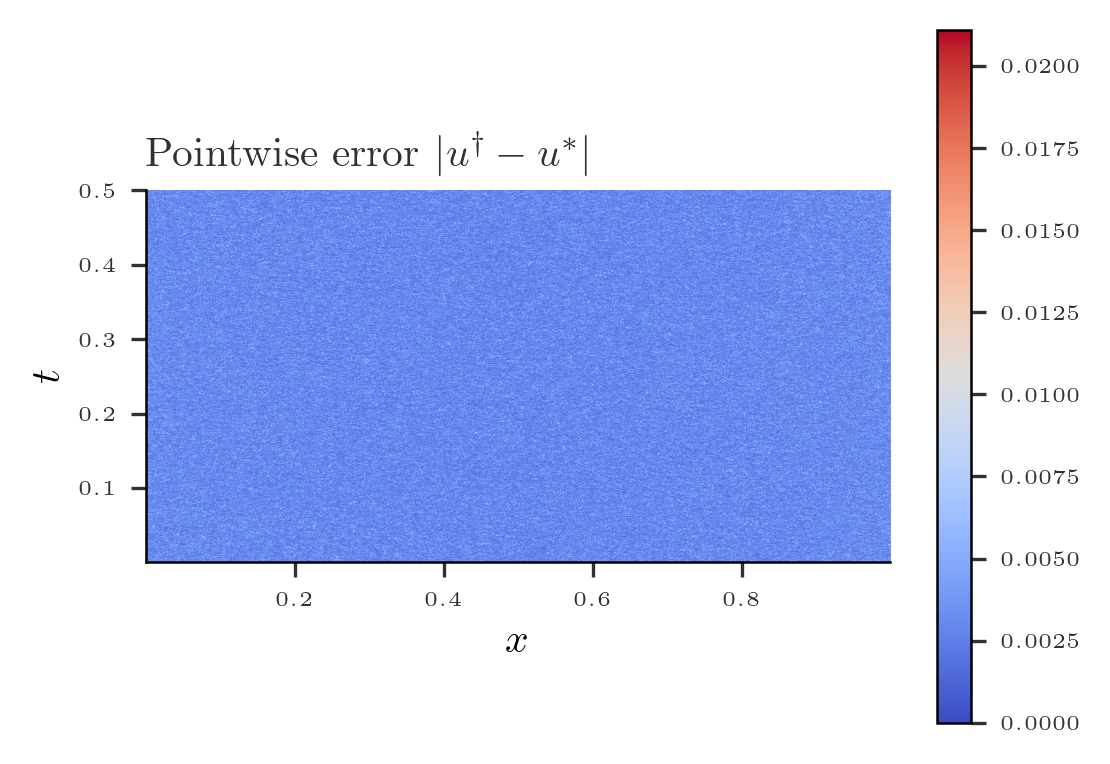

In [260]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_kernel - u_values_T[1:]), cmap='coolwarm', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Coarser in time

In [261]:
coarse_factor = 5
h = h_spectral*coarse_factor

time_span = jnp.arange(0, T+h, h)
time_span_spectral = jnp.arange(0, T+h_spectral, h_spectral) 
b =lambda x : jnp.ones_like(x)
root_b= b(k_quad)
length_scale = 0.1

In [262]:
1/n_meas**2, h

(9.555396935966418e-07, 0.0005)

In [263]:
time_span_spectral[coarse_factor::coarse_factor]

Array([0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035, 0.004 ,
       0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075, 0.008 ,
       0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115, 0.012 ,
       0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155, 0.016 ,
       0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195, 0.02  ,
       0.0205, 0.021 , 0.0215, 0.022 , 0.0225, 0.023 , 0.0235, 0.024 ,
       0.0245, 0.025 , 0.0255, 0.026 , 0.0265, 0.027 , 0.0275, 0.028 ,
       0.0285, 0.029 , 0.0295, 0.03  , 0.0305, 0.031 , 0.0315, 0.032 ,
       0.0325, 0.033 , 0.0335, 0.034 , 0.0345, 0.035 , 0.0355, 0.036 ,
       0.0365, 0.037 , 0.0375, 0.038 , 0.0385, 0.039 , 0.0395, 0.04  ,
       0.0405, 0.041 , 0.0415, 0.042 , 0.0425, 0.043 , 0.0435, 0.044 ,
       0.0445, 0.045 , 0.0455, 0.046 , 0.0465, 0.047 , 0.0475, 0.048 ,
       0.0485, 0.049 , 0.0495, 0.05  , 0.0505, 0.051 , 0.0515, 0.052 ,
       0.0525, 0.053 , 0.0535, 0.054 , 0.0545, 0.055 , 0.0555, 0.056 ,
      

In [264]:
linear_solver = kernel_linear_solver(length_scale, tent_quad, k_quad,  boundary[:, None], boundary_conditions, h*nu)


start = time.time()
linear_solver.build_matrices(root_b)
linear_solver.create_K_psi()
linear_solver.create_K_eval(domain_finest)
end = time.time()
print("Time to build the matrices", jnp.round(end - start, 5))

Time to build the matrices 0.2353


In [265]:
BM_coarse = BM.reshape(n_coef, time_span_spectral[1:].shape[0] // coarse_factor, coarse_factor)
BM_coarse = jnp.sum(BM_coarse, axis = -1)
xi_tent_coarse = tent_proj_coef@BM_coarse*jnp.sqrt(h_spectral)
#jnp.cumsum(BM[0])[::coarse_factor]

In [266]:
BM_coarse

Array([[ 3.35834738,  0.93130825,  2.39819436, ...,  1.90494587,
        -0.38291635,  2.18931311],
       [-0.99811839, -1.44888186, -0.73238649, ..., -1.90982033,
        -0.37094367,  0.50222978],
       [ 0.24656632,  2.9388662 , -1.89637117, ...,  2.85414411,
         1.26472493,  1.3405574 ],
       ...,
       [-2.03508875,  2.48484076,  1.75227055, ...,  2.67476938,
         2.90787396, -1.1540236 ],
       [ 2.04648181, -0.68000258, -2.94714077, ..., -0.25607925,
        -1.6994674 , -0.1618091 ],
       [-2.62562706,  1.90397283, -0.37285947, ..., -0.74544063,
         2.44024067, -0.54406889]], dtype=float64)

In [267]:
jnp.sum(BM[:, :coarse_factor], axis = -1), jnp.sum(BM[:, coarse_factor:coarse_factor*2], axis = -1)

(Array([ 3.35834738, -0.99811839,  0.24656632, ..., -2.03508875,
         2.04648181, -2.62562706], dtype=float64),
 Array([ 0.93130825, -1.44888186,  2.9388662 , ...,  2.48484076,
        -0.68000258,  1.90397283], dtype=float64))

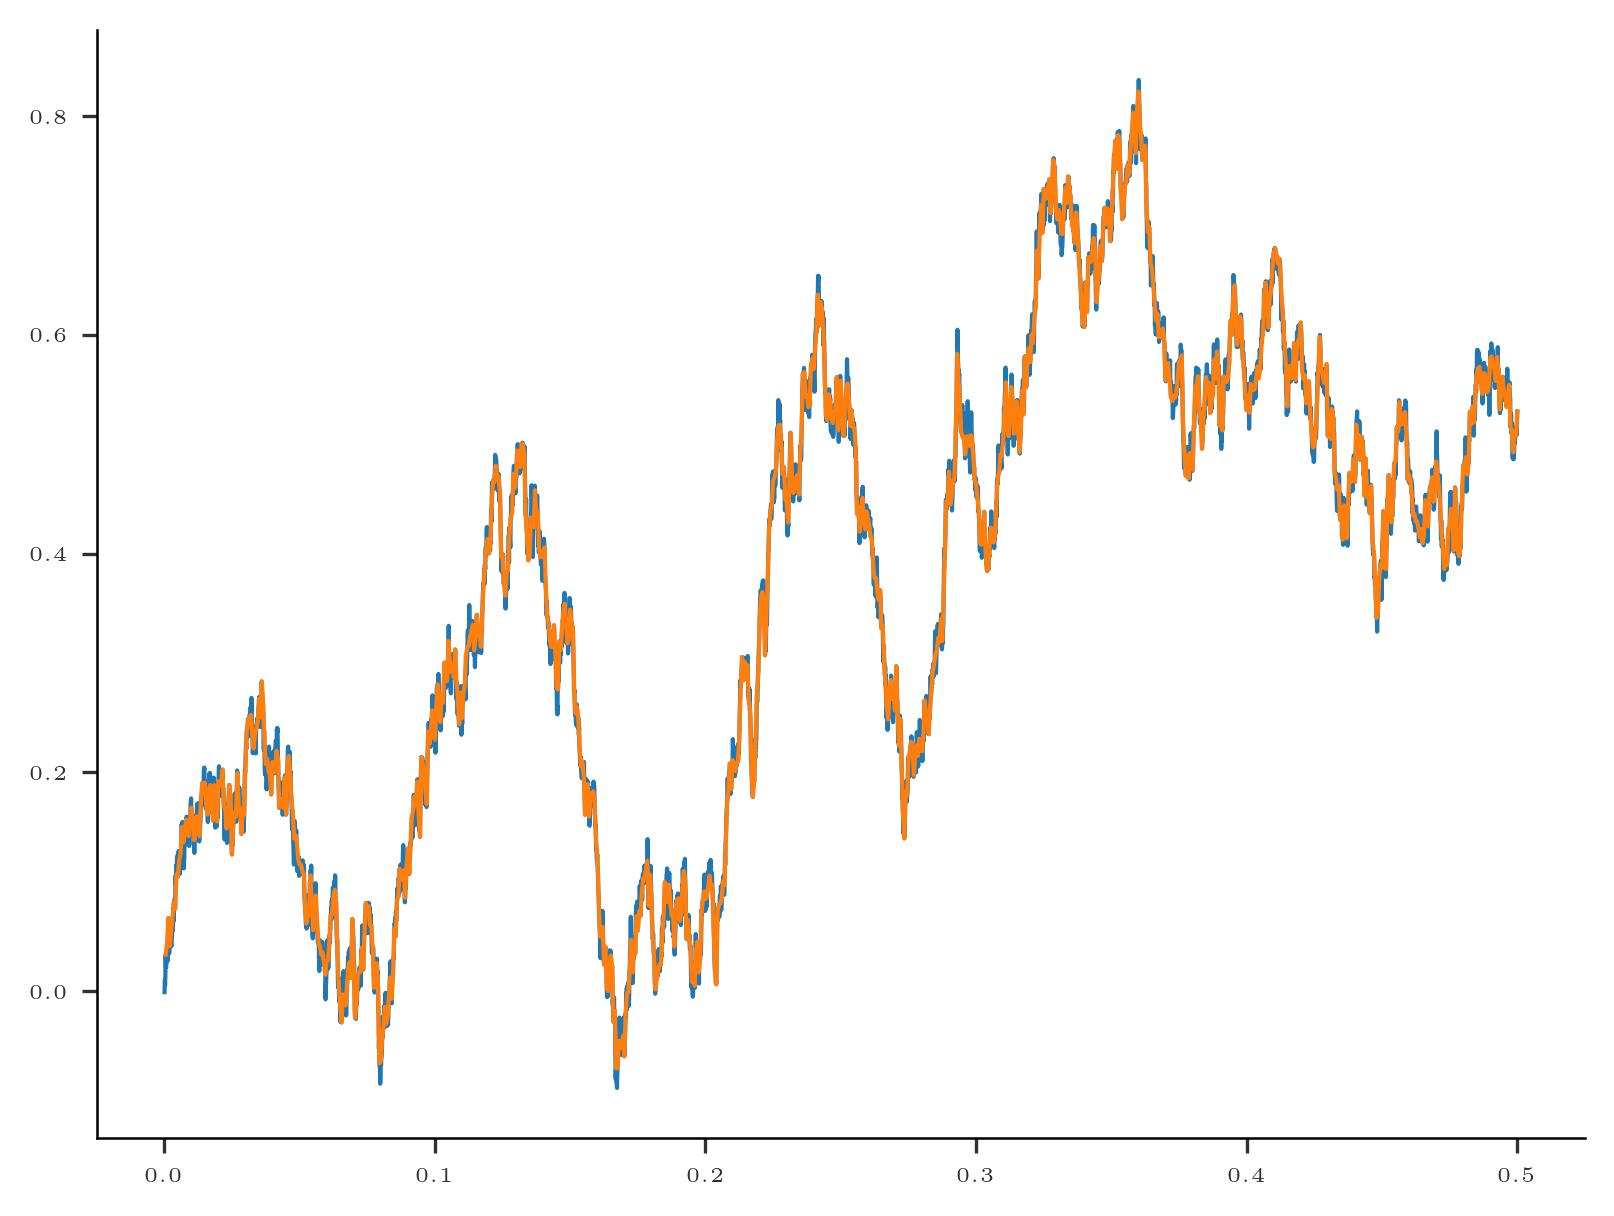

In [268]:
plt.plot(time_span_spectral[1:], jnp.cumsum(BM[0])*jnp.sqrt(h_spectral))
plt.plot(time_span[1:], jnp.cumsum(BM_coarse[0])*jnp.sqrt(h_spectral))

In [269]:
start = time.time()
y, linear_solver, c_kernel_history= implicit_EM_solver(time_span[1:], h, linear_solver, g_tent, sigma,xi_tent_coarse)
end = time.time()
print("Time to integrate the system", jnp.round(end - start, 5))

Time to integrate the system 4.253500000000001


In [270]:
pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)

In [271]:
pred_kernel.shape, time_span.shape

((1000, 2048), (1001,))

In [272]:
u_coarse = u_values_T[coarse_factor::coarse_factor]

In [273]:
compute_2d_error(pred_kernel, u_coarse, domain_finest, time_span[1:])

(Array(0.00428167, dtype=float64), Array(0.00693954, dtype=float64))

In [274]:
error_T, rel_error_T = vmap(compute_1d_error, in_axes=(0, 0, None))(pred_kernel, u_coarse, domain_finest)

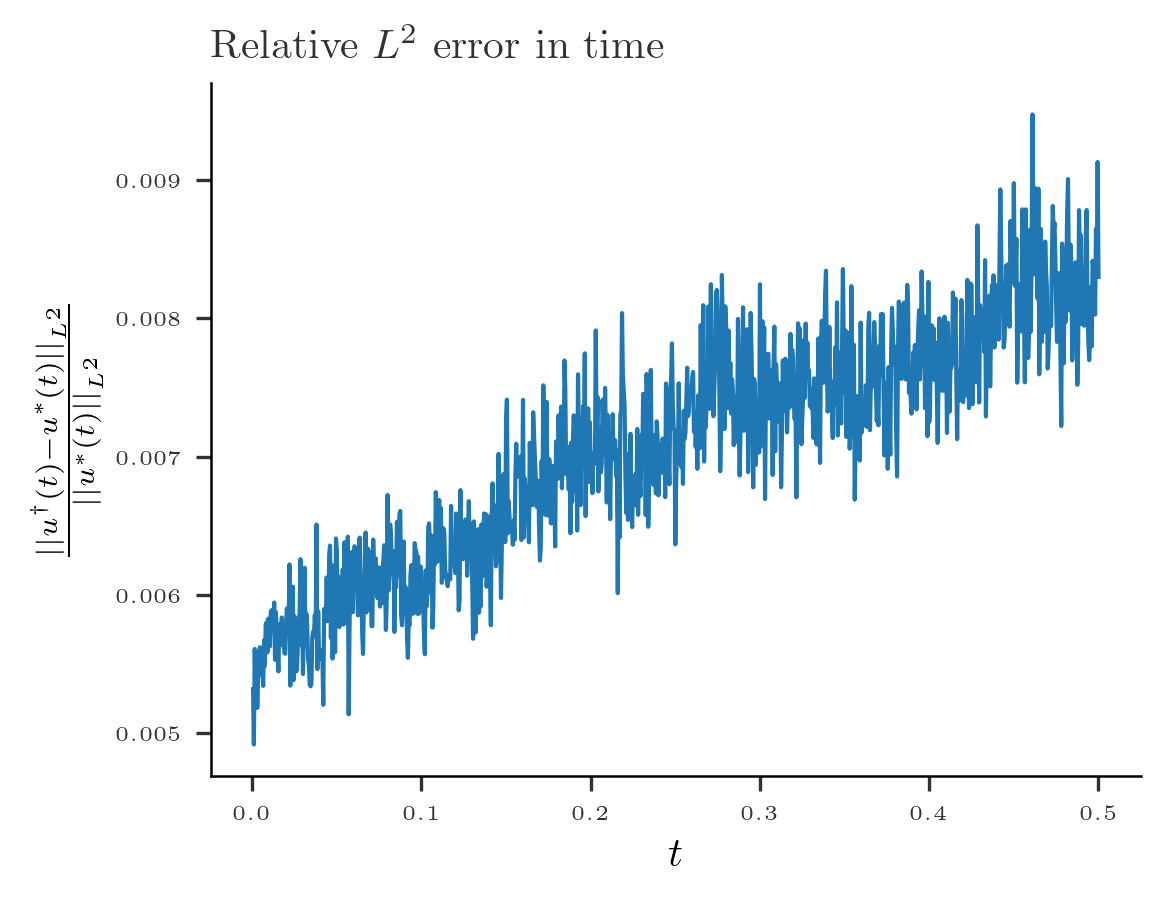

In [275]:
# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(time_span[1:], rel_error_T)
plt.xlabel(r"$t$")
plt.ylabel(r"$\frac{||u^\dagger(t)-u^*(t) ||_{L^2}}{||u^*(t)||_{L^2}}$")
plt.title(r"Relative $L^2$ error in time")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

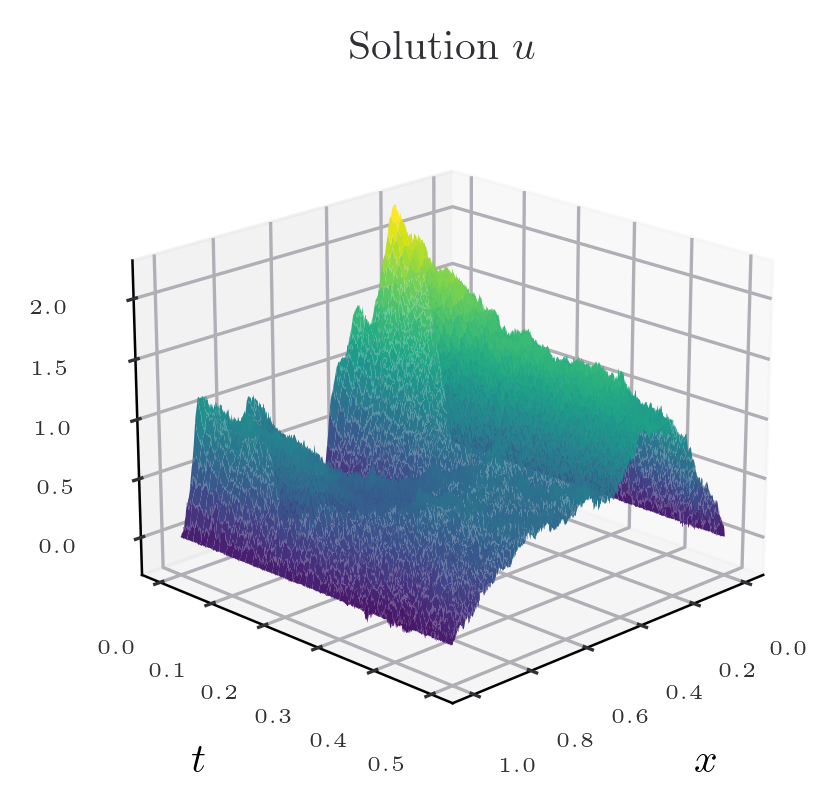

In [280]:

# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

X, time_grid = jnp.meshgrid(domain_finest, time_span[1:])
stride = 25
ax.plot_surface(X, time_grid, pred_kernel,  cmap='viridis',  rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

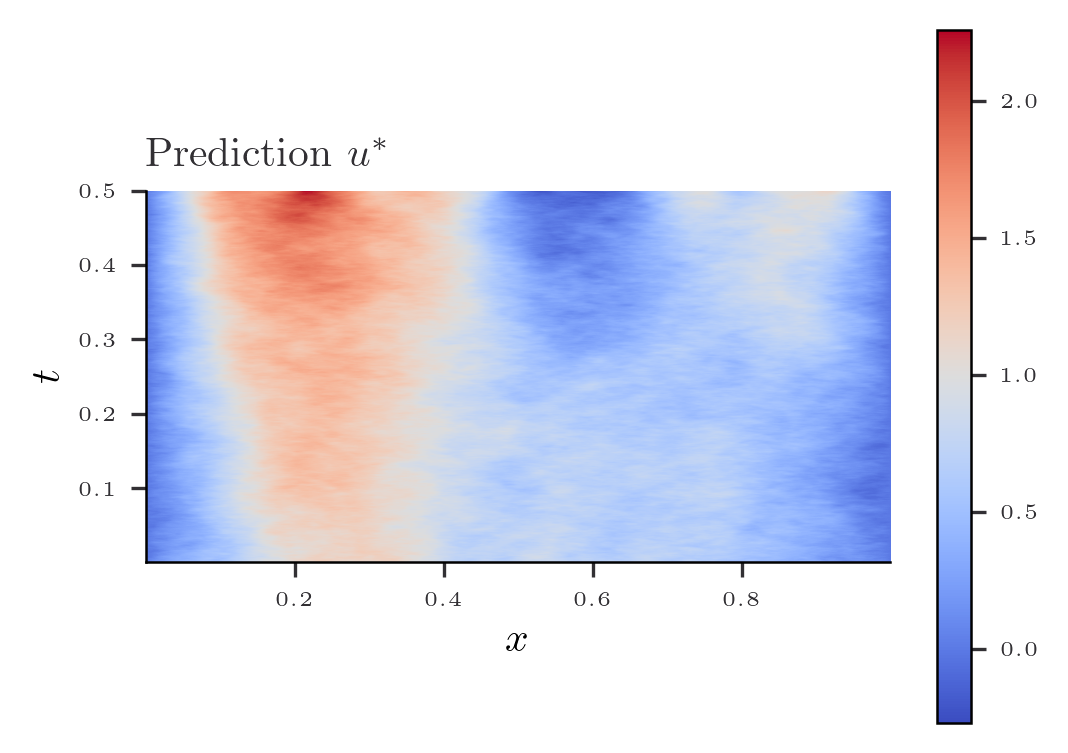

In [277]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_kernel, cmap='coolwarm', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Prediction $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

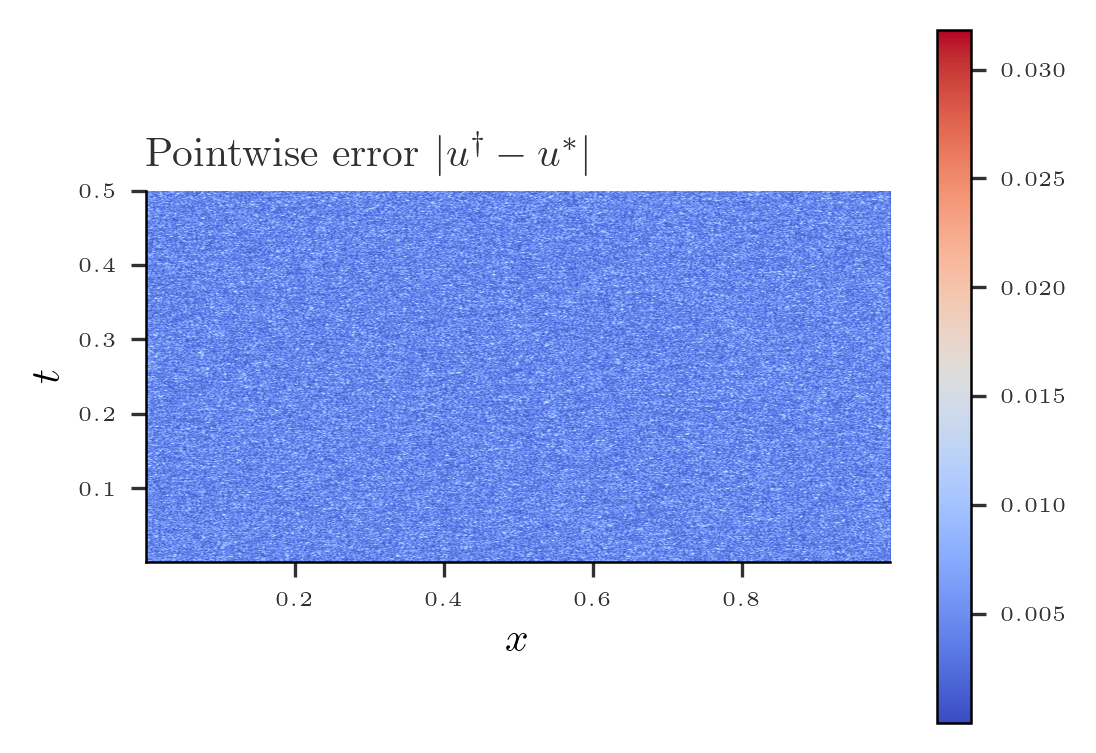

In [278]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_kernel - u_coarse), cmap='coolwarm', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

In [323]:
BM.shape, time_span[1:].shape

((8192, 500), (50,))

In [275]:
BM.shape

(8192, 499)

In [ ]:
xi_tent_coarse = tent_proj_coef@BM